In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, brier_score_loss

import xgboost as xgb
from keras_tuner import HyperParameters
from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vl_convert as vlc

%matplotlib inline


In [13]:
# Load data
DataStep7 = pd.read_feather('./Data/V2-DataStep7.feather')

# Define X and y
X = DataStep7.drop(columns=['Cluster'])
y = DataStep7['Cluster']

# 创建 LabelEncoder 对象
label_encoder = LabelEncoder()

# 将 y 中的标签转换为数值
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),           # Normalize numeric columns
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical columns
    ])

# Create the complete pipeline with zero-variance feature removal
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('variance_threshold', VarianceThreshold())           # Remove zero-variance columns
])

# Fit the pipeline to the training data
pipeline.fit(X_train)

# Transform the training and test sets
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [14]:
# 构建模型函数
def build_model(hp):
    model = Sequential()

    # 添加层数，使用 hp.Int 动态设置层数
    for i in range(hp.Int('num_layers', 1, 5)):  # 1到5层
        model.add(Dense(
            units=hp.Choice(f'units_{i}', [3, 5, 7, 10]),  # 每层的神经元数量
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.05)))  # Dropout

    model.add(Dense(1, activation='sigmoid'))  # 最后一层，二分类

    # 优化器选择
    optimizer_options = {
        'Adam': Adam,
        'Adamax': Adamax,
        'SGD': SGD,
        'RMSprop': RMSprop
    }

    # 使用 hp.Choice 动态选择优化器
    optimizer_name = hp.Choice('optimizer', ['Adam', 'Adamax', 'SGD', 'RMSprop'])
    optimizer = optimizer_options[optimizer_name](
        learning_rate=hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
    )

    # 编译模型
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 初始化 Bayesian Optimization Tuner
tuner = BayesianOptimization(
    build_model,  # 模型构建函数
    objective='val_accuracy',  # 优化目标
    max_trials=100,  # 最大搜索次数
    executions_per_trial=1,  # 每次搜索模型训练的次数
    directory='./dir',  # 保存搜索结果的目录
    project_name='V2-bayesion'  # 项目名称
)

# 输出搜索空间摘要
tuner.search_space_summary()


# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=50,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch once training is stopped
)

# 开始搜索最佳超参数
tuner.search(
    X_train_transformed, y_train,
    epochs=100,  # 设置训练的 epoch 数
    batch_size=HyperParameters().Choice('batch_size', [128, 256, 512, 1024]),  # 选择 batch_size
    validation_data=(X_test_transformed, y_test),
    callbacks=[early_stopping]  # 可选: 可以添加早停等回调
)

# 获得最佳超参数
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

ann_best = tuner.hypermodel.build(best_hps)
ann_best.fit(
    X_train_transformed, y_train,
    validation_data=(X_test_transformed, y_test),
    epochs=100,
    batch_size=512
)

best_hyperparameters = best_hps.values
print(best_hyperparameters)

Reloading Tuner from ./dir\V2-bayesion\tuner0.json
Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7, 10], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'Adamax', 'SGD', 'RMSprop'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
units_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7, 10], 'ordered': True}
units_2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7, 10], 'ordered': True}
units_3 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7, 10], 'ordered': True}
units_4 (Choice)
{'default': 3, 

In [31]:
def evaluate_model_metrics(model, X_train, y_train, X_val, y_val):
        
    if model is ann_best:
        # 训练集预测概率
        y_train_pred_prob = model.predict(X_train)  # 获取概率
        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
        roc_auc_train = auc(fpr_train, tpr_train)
        
        # 获取预测概率
        n_bootstrap = 1000
        rng_seed = 42  # 固定随机种子以保证可重复性    

        # 存储每次 bootstrap 的 AUC
        bootstrapped_auc_train = []
        bootstrapped_auccuracy_train = []
        bootstrapped_precision_train = []
        bootstrapped_sensitivity_train = []
        bootstrapped_specificity_train = []
        bootstrapped_f1_train = []
        bootstrapped_brier_train = []

        bootstrapped_auc_val = []
        bootstrapped_auccuracy_val = []
        bootstrapped_precision_val = []
        bootstrapped_sensitivity_val = []
        bootstrapped_specificity_val = []
        bootstrapped_f1_val = []
        bootstrapped_brier_val = []

        # 设置随机数生成器
        rng = np.random.RandomState(rng_seed)
        
        # 验证集预测概率
        y_val_pred_prob = model.predict(X_val)  # 获取概率
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_prob)
        roc_auc_val = auc(fpr_val, tpr_val)
    
        y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

        for _ in range(n_bootstrap):
            # 有放回抽样
            indices = rng.randint(0, len(y_train), len(y_train))
            if len(np.unique(y_train[indices])) < 2:
                # 如果样本中没有两个类别，跳过当前抽样
                continue
            score = roc_auc_score(y_train[indices], y_train_pred_prob[indices])
            accuracyscore = accuracy_score(y_train[indices], y_train_pred[indices])
            precisionscore = precision_score(y_train[indices], y_train_pred[indices])
            sensitivityscore = recall_score(y_train[indices], y_train_pred[indices])
            tn, fp, fn, tp = confusion_matrix(y_train[indices], y_train_pred[indices]).ravel()
            specificityscore = tn / (tn + fp)
            f1score = f1_score(y_train[indices], y_train_pred[indices])
            brierscore = brier_score_loss(y_train[indices], y_train_pred_prob[indices])

            bootstrapped_auc_train.append(score)
            bootstrapped_auccuracy_train.append(accuracyscore)
            bootstrapped_precision_train.append(precisionscore)
            bootstrapped_sensitivity_train.append(sensitivityscore)
            bootstrapped_specificity_train.append(specificityscore)
            bootstrapped_f1_train.append(f1score)
            bootstrapped_brier_train.append(brierscore)

        # 计算置信区间
        alpha = 0.95  # 置信水平 95%
        lower_train = np.percentile(bootstrapped_auc_train, (1 - alpha) / 2 * 100)
        accuracy_lower_train = np.percentile(bootstrapped_auccuracy_train, (1 - alpha) / 2 * 100)
        precision_lower_train = np.percentile(bootstrapped_precision_train, (1 - alpha) / 2 * 100)
        sensitivity_lower_train = np.percentile(bootstrapped_sensitivity_train, (1 - alpha) / 2 * 100)
        specificity_lower_train = np.percentile(bootstrapped_specificity_train, (1 - alpha) / 2 * 100)
        f1_lower_train = np.percentile(bootstrapped_f1_train, (1 - alpha) / 2 * 100)
        brier_lower_train = np.percentile(bootstrapped_brier_train, (1 - alpha) / 2 * 100)

        upper_train = np.percentile(bootstrapped_auc_train, (alpha + (1 - alpha) / 2) * 100)
        accuracy_upper_train = np.percentile(bootstrapped_auccuracy_train, (alpha + (1 - alpha) / 2) * 100)
        precision_upper_train = np.percentile(bootstrapped_precision_train, (alpha + (1 - alpha) / 2) * 100)
        sensitivity_upper_train = np.percentile(bootstrapped_sensitivity_train, (alpha + (1 - alpha) / 2) * 100)
        specificity_upper_train = np.percentile(bootstrapped_specificity_train, (alpha + (1 - alpha) / 2) * 100)
        f1_upper_train = np.percentile(bootstrapped_f1_train, (alpha + (1 - alpha) / 2) * 100)
        brier_upper_train = np.percentile(bootstrapped_brier_train, (alpha + (1 - alpha) / 2) * 100)

        # 输出 AUC 和 置信区间
        roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)

        for _ in range(n_bootstrap):
            # 有放回抽样
            indices = rng.randint(0, len(y_val), len(y_val))
            if len(np.unique(y_val[indices])) < 2:
                # 如果样本中没有两个类别，跳过当前抽样
                continue
            score = roc_auc_score(y_val[indices], y_val_pred_prob[indices])
            accuracyscore = accuracy_score(y_val, y_val_pred)
            precisionscore = precision_score(y_val[indices], y_val_pred[indices])
            sensitivityscore = recall_score(y_val[indices], y_val_pred[indices])
            tn, fp, fn, tp = confusion_matrix(y_val[indices], y_val_pred[indices]).ravel()
            specificityscore = tn / (tn + fp)
            f1score = f1_score(y_val[indices], y_val_pred[indices])
            brierscore = brier_score_loss(y_val[indices], y_val_pred_prob[indices])

            bootstrapped_auc_val.append(score)
            bootstrapped_auccuracy_val.append(accuracyscore)
            bootstrapped_precision_val.append(precisionscore)
            bootstrapped_sensitivity_val.append(sensitivityscore)
            bootstrapped_specificity_val.append(specificityscore)
            bootstrapped_f1_val.append(f1score)
            bootstrapped_brier_val.append(brierscore)

       # 计算置信区间
        alpha = 0.95  # 置信水平 95%
        lower_val = np.percentile(bootstrapped_auc_val, (1 - alpha) / 2 * 100)
        accuracy_lower_val = np.percentile(bootstrapped_auccuracy_val, (1 - alpha) / 2 * 100)
        precision_lower_val = np.percentile(bootstrapped_precision_val, (1 - alpha) / 2 * 100)
        sensitivity_lower_val = np.percentile(bootstrapped_sensitivity_val, (1 - alpha) / 2 * 100)
        specificity_lower_val = np.percentile(bootstrapped_specificity_val, (1 - alpha) / 2 * 100)
        f1_lower_val = np.percentile(bootstrapped_f1_val, (1 - alpha) / 2 * 100)
        brier_lower_val = np.percentile(bootstrapped_brier_val, (1 - alpha) / 2 * 100)

        upper_val = np.percentile(bootstrapped_auc_val, (alpha + (1 - alpha) / 2) * 100)
        accuracy_upper_val = np.percentile(bootstrapped_auccuracy_val, (alpha + (1 - alpha) / 2) * 100)
        precision_upper_val = np.percentile(bootstrapped_precision_val, (alpha + (1 - alpha) / 2) * 100)
        sensitivity_upper_val = np.percentile(bootstrapped_sensitivity_val, (alpha + (1 - alpha) / 2) * 100)
        specificity_upper_val = np.percentile(bootstrapped_specificity_val, (alpha + (1 - alpha) / 2) * 100)
        f1_upper_val = np.percentile(bootstrapped_f1_val, (alpha + (1 - alpha) / 2) * 100)
        brier_upper_val = np.percentile(bootstrapped_brier_val, (alpha + (1 - alpha) / 2) * 100)
        # 输出 AUC 和 置信区间
        roc_auc_val = roc_auc_score(y_val, y_val_pred_prob)

    else:
        # 获取预测概率
        n_bootstrap = 1000
        rng_seed = 42  # 固定随机种子以保证可重复性

        # 存储每次 bootstrap 的 AUC
        bootstrapped_auc_train = []
        bootstrapped_auccuracy_train = []
        bootstrapped_precision_train = []
        bootstrapped_sensitivity_train = []
        bootstrapped_specificity_train = []
        bootstrapped_f1_train = []
        bootstrapped_brier_train = []

        bootstrapped_auc_val = []
        bootstrapped_auccuracy_val = []
        bootstrapped_precision_val = []
        bootstrapped_sensitivity_val = []
        bootstrapped_specificity_val = []
        bootstrapped_f1_val = []
        bootstrapped_brier_val = []

        # 设置随机数生成器
        rng = np.random.RandomState(rng_seed)

        y_train_pred_prob = model.predict_proba(X_train)[:, 1]
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    
        # 将预测的概率值转化为二进制分类结果
        y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_prob)
        roc_auc_train = auc(fpr_train, tpr_train)
        roc_auc_val = auc(fpr_val, tpr_val)


        for _ in range(n_bootstrap):
            # 有放回抽样
            indices = rng.randint(0, len(y_train), len(y_train))
            if len(np.unique(y_train[indices])) < 2:
                # 如果样本中没有两个类别，跳过当前抽样
                continue
            score = roc_auc_score(y_train[indices], y_train_pred_prob[indices])
            accuracyscore = accuracy_score(y_train[indices], y_train_pred[indices])
            precisionscore = precision_score(y_train[indices], y_train_pred[indices])
            sensitivityscore = recall_score(y_train[indices], y_train_pred[indices])
            tn, fp, fn, tp = confusion_matrix(y_train[indices], y_train_pred[indices]).ravel()
            specificityscore = tn / (tn + fp)
            f1score = f1_score(y_train[indices], y_train_pred[indices])
            brierscore = brier_score_loss(y_train[indices], y_train_pred_prob[indices])

            bootstrapped_auc_train.append(score)
            bootstrapped_auccuracy_train.append(accuracyscore)
            bootstrapped_precision_train.append(precisionscore)
            bootstrapped_sensitivity_train.append(sensitivityscore)
            bootstrapped_specificity_train.append(specificityscore)
            bootstrapped_f1_train.append(f1score)
            bootstrapped_brier_train.append(brierscore)

        # 计算置信区间
        alpha = 0.95  # 置信水平 95%
        lower_train = np.percentile(bootstrapped_auc_train, (1 - alpha) / 2 * 100)
        accuracy_lower_train = np.percentile(bootstrapped_auccuracy_train, (1 - alpha) / 2 * 100)
        precision_lower_train = np.percentile(bootstrapped_precision_train, (1 - alpha) / 2 * 100)
        sensitivity_lower_train = np.percentile(bootstrapped_sensitivity_train, (1 - alpha) / 2 * 100)
        specificity_lower_train = np.percentile(bootstrapped_specificity_train, (1 - alpha) / 2 * 100)
        f1_lower_train = np.percentile(bootstrapped_f1_train, (1 - alpha) / 2 * 100)
        brier_lower_train = np.percentile(bootstrapped_brier_train, (1 - alpha) / 2 * 100)

        upper_train = np.percentile(bootstrapped_auc_train, (alpha + (1 - alpha) / 2) * 100)
        accuracy_upper_train = np.percentile(bootstrapped_auccuracy_train, (alpha + (1 - alpha) / 2) * 100)
        precision_upper_train = np.percentile(bootstrapped_precision_train, (alpha + (1 - alpha) / 2) * 100)
        sensitivity_upper_train = np.percentile(bootstrapped_sensitivity_train, (alpha + (1 - alpha) / 2) * 100)
        specificity_upper_train = np.percentile(bootstrapped_specificity_train, (alpha + (1 - alpha) / 2) * 100)
        f1_upper_train = np.percentile(bootstrapped_f1_train, (alpha + (1 - alpha) / 2) * 100)
        brier_upper_train = np.percentile(bootstrapped_brier_train, (alpha + (1 - alpha) / 2) * 100)

        # 输出 AUC 和 置信区间
        roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)

        for _ in range(n_bootstrap):
            # 有放回抽样
            indices = rng.randint(0, len(y_val), len(y_val))
            if len(np.unique(y_val[indices])) < 2:
                # 如果样本中没有两个类别，跳过当前抽样
                continue
            score = roc_auc_score(y_val[indices], y_val_pred_prob[indices])
            accuracyscore = accuracy_score(y_val, y_val_pred)
            precisionscore = precision_score(y_val[indices], y_val_pred[indices])
            sensitivityscore = recall_score(y_val[indices], y_val_pred[indices])
            tn, fp, fn, tp = confusion_matrix(y_val[indices], y_val_pred[indices]).ravel()
            specificityscore = tn / (tn + fp)
            f1score = f1_score(y_val[indices], y_val_pred[indices])
            brierscore = brier_score_loss(y_val[indices], y_val_pred_prob[indices])

            bootstrapped_auc_val.append(score)
            bootstrapped_auccuracy_val.append(accuracyscore)
            bootstrapped_precision_val.append(precisionscore)
            bootstrapped_sensitivity_val.append(sensitivityscore)
            bootstrapped_specificity_val.append(specificityscore)
            bootstrapped_f1_val.append(f1score)
            bootstrapped_brier_val.append(brierscore)
            
        # 计算置信区间
        alpha = 0.95  # 置信水平 95%
        lower_val = np.percentile(bootstrapped_auc_val, (1 - alpha) / 2 * 100)
        accuracy_lower_val = np.percentile(bootstrapped_auccuracy_val, (1 - alpha) / 2 * 100)
        precision_lower_val = np.percentile(bootstrapped_precision_val, (1 - alpha) / 2 * 100)
        sensitivity_lower_val = np.percentile(bootstrapped_sensitivity_val, (1 - alpha) / 2 * 100)
        specificity_lower_val = np.percentile(bootstrapped_specificity_val, (1 - alpha) / 2 * 100)
        f1_lower_val = np.percentile(bootstrapped_f1_val, (1 - alpha) / 2 * 100)
        brier_lower_val = np.percentile(bootstrapped_brier_val, (1 - alpha) / 2 * 100)

        upper_val = np.percentile(bootstrapped_auc_val, (alpha + (1 - alpha) / 2) * 100)
        accuracy_upper_val = np.percentile(bootstrapped_auccuracy_val, (alpha + (1 - alpha) / 2) * 100)
        precision_upper_val = np.percentile(bootstrapped_precision_val, (alpha + (1 - alpha) / 2) * 100)
        sensitivity_upper_val = np.percentile(bootstrapped_sensitivity_val, (alpha + (1 - alpha) / 2) * 100)
        specificity_upper_val = np.percentile(bootstrapped_specificity_val, (alpha + (1 - alpha) / 2) * 100)
        f1_upper_val = np.percentile(bootstrapped_f1_val, (alpha + (1 - alpha) / 2) * 100)
        brier_upper_val = np.percentile(bootstrapped_brier_val, (alpha + (1 - alpha) / 2) * 100)
        # 输出 AUC 和 置信区间
        roc_auc_val = roc_auc_score(y_val, y_val_pred_prob)

    
    # 计算各项指标
    metrics = {}
    
    # Accuracy
    metrics['train_accuracy'] = accuracy_score(y_train, y_train_pred)
    metrics['train_accuracy_low'] = accuracy_lower_train
    metrics['train_accuracy_upper'] =accuracy_upper_train

    metrics['val_accuracy'] = accuracy_score(y_val, y_val_pred)
    metrics['val_accuracy_low'] = accuracy_lower_val
    metrics['val_accuracy_upper'] =accuracy_upper_val

    # Precision
    metrics['train_precision'] = precision_score(y_train, y_train_pred)
    metrics['precision_lower_train'] = precision_lower_train
    metrics['precision_upper_train'] =precision_upper_train

    metrics['val_precision'] = precision_score(y_val, y_val_pred)
    metrics['precision_lower_val'] = precision_lower_val
    metrics['precision_upper_val'] =precision_upper_val   

    # Sensitivity (Recall)
    metrics['train_sensitivity'] = recall_score(y_train, y_train_pred)
    metrics['sensitivity_lower_train'] = sensitivity_lower_train
    metrics['sensitivity_upper_train'] =sensitivity_upper_train

    metrics['val_sensitivity'] = recall_score(y_val, y_val_pred)
    metrics['sensitivity_lower_val'] = sensitivity_lower_val
    metrics['sensitivity_upper_val'] =sensitivity_upper_val

    # Specificity (TN / (TN + FP))
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    metrics['train_specificity'] = tn / (tn + fp)
    metrics['specificity_lower_train'] = specificity_lower_train
    metrics['specificity_upper_train'] =specificity_upper_train

    tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
    metrics['val_specificity'] = tn / (tn + fp)
    metrics['specificity_lower_val'] = specificity_lower_val
    metrics['specificity_upper_val'] =specificity_upper_val
    
    # F1 Score
    metrics['train_f1'] = f1_score(y_train, y_train_pred)
    metrics['f1_lower_train'] = f1_lower_train
    metrics['f1_upper_train'] =f1_upper_train

    metrics['val_f1'] = f1_score(y_val, y_val_pred)
    metrics['f1_lower_val'] = f1_lower_val
    metrics['f1_upper_val'] =f1_upper_val

    # Brier Score
    metrics['train_brier'] = brier_score_loss(y_train, y_train_pred_prob)
    metrics['brier_lower_train'] = brier_lower_train
    metrics['brier_upper_train'] =brier_upper_train

    metrics['val_brier'] = brier_score_loss(y_val, y_val_pred_prob)
    metrics['brier_lower_val'] = brier_lower_val
    metrics['brier_upper_val'] =brier_upper_val
    
    metrics['train_roc_auc'] = roc_auc_train
    metrics['val_roc_auc'] = roc_auc_val
    
    metrics['train_roc_auc_ci_low'] = lower_train
    metrics['train_roc_auc_ci_upper'] = upper_train

    metrics['val_roc_auc_ci_low'] = lower_val
    metrics['val_roc_auc_ci_upper'] = upper_val

    return metrics, fpr_train, tpr_train, fpr_val, tpr_val



In [16]:
# Best parameters obtained from the search
best_params = {'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'distance'}

# Create and fit the KNN model with the best parameters
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_transformed, y_train)


KNeighborsClassifier(n_neighbors=100, weights='distance')

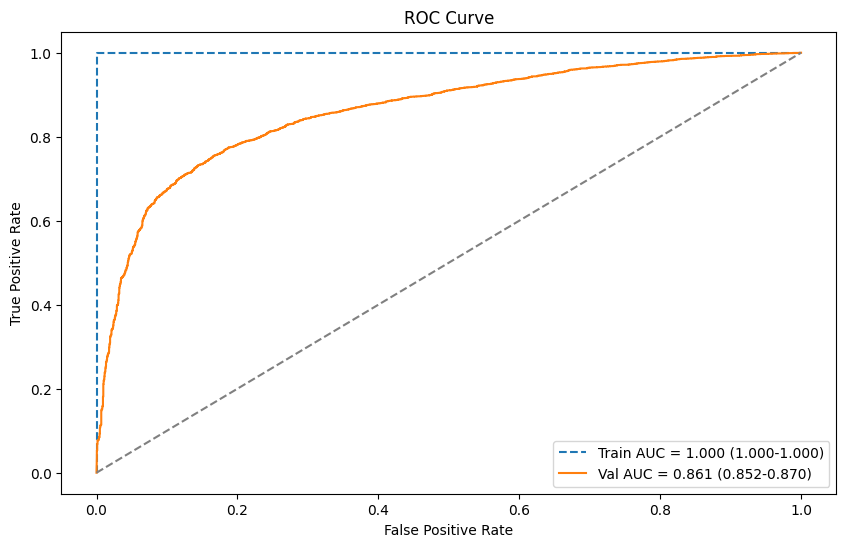

In [17]:
def plot_roc_curves(model, X_train, y_train, X_val, y_val):
    plt.figure(figsize=(10, 6))
    
    # Evaluate the model
    metrics, fpr_train, tpr_train, fpr_val, tpr_val = evaluate_model_metrics(model, X_train, y_train, X_val, y_val)
        
    # Plot ROC curve for train and validation sets
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {metrics["train_roc_auc"]:.3f} ({metrics["train_roc_auc_ci_low"]:.3f}-{metrics["train_roc_auc_ci_upper"]:.3f})', linestyle='--')
    plt.plot(fpr_val, tpr_val, label=f'Val AUC = {metrics["val_roc_auc"]:.3f} ({metrics["val_roc_auc_ci_low"]:.3f}-{metrics["val_roc_auc_ci_upper"]:.3f})', linestyle='-')

    # Add diagonal line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

evaluate_model_metrics(knn_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
# Call the function with a single model
plot_roc_curves(knn_best, X_train_transformed, y_train, X_test_transformed, y_test)


In [18]:
best_params = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
# Create and fit the KNN model with the best parameters
logistic_best = LogisticRegression(**best_params)
logistic_best.fit(X_train_transformed, y_train)

LogisticRegression(C=0.01)

In [19]:
# SVM Best parameters: OrderedDict([('C', 1), ('gamma', 'scale'), ('kernel', 'rbf')])
best_params = {'C':10, 'gamma':0.001, 'kernel':'sigmoid'}
# Create and fit the KNN model with the best parameters
SVM_best = SVC(**best_params, probability=True)
SVM_best.fit(X_train_transformed, y_train)

SVC(C=10, gamma=0.001, kernel='sigmoid', probability=True)

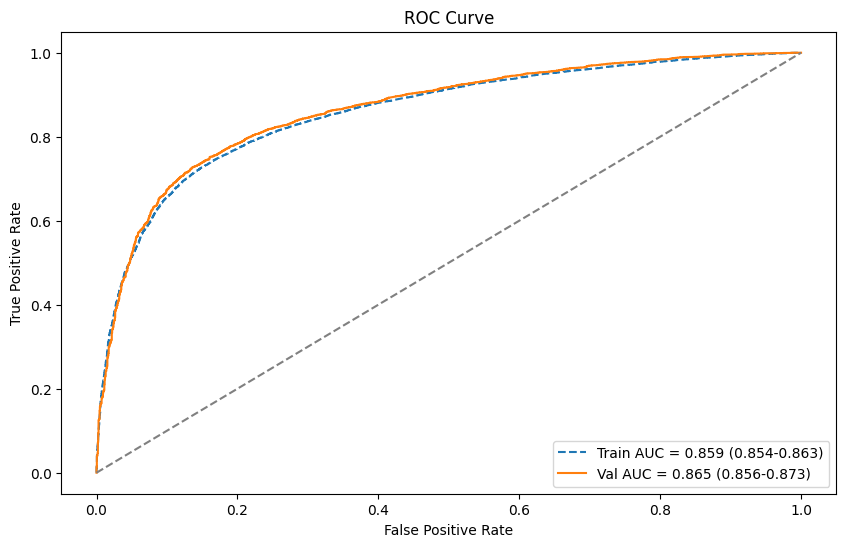

In [20]:
evaluate_model_metrics(SVM_best, X_train_transformed, y_train, X_test_transformed, y_test)
plot_roc_curves(SVM_best, X_train_transformed, y_train, X_test_transformed, y_test)

In [21]:
# random forest Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', None), ('min_samples_leaf', 3), ('min_samples_split', 15), ('n_estimators', 700)])
best_params = {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'sqrt',
               'min_samples_leaf': 13, 'min_samples_split': 9, 'n_estimators': 900}
# Create and fit the KNN model with the best parameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train_transformed, y_train)

RandomForestClassifier(criterion='entropy', max_depth=13, min_samples_leaf=13,
                       min_samples_split=9, n_estimators=900)

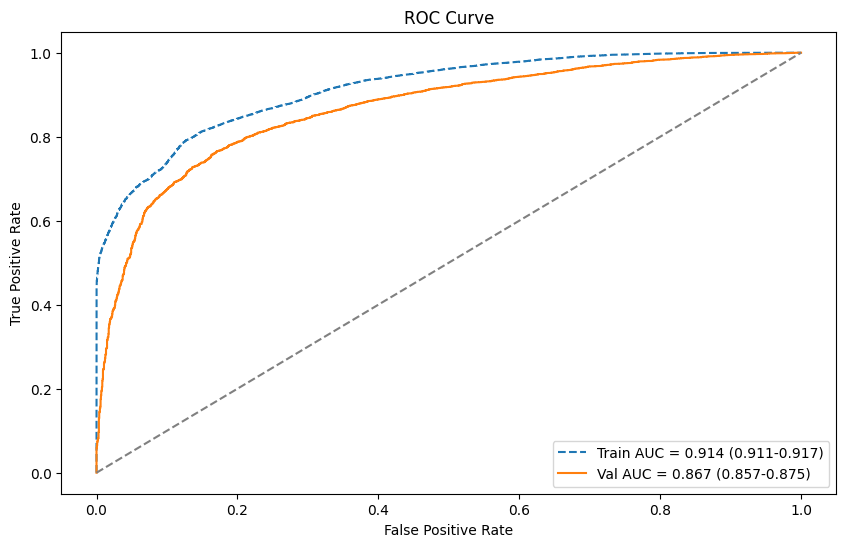

In [22]:
evaluate_model_metrics(rf_best, X_train_transformed, y_train, X_test_transformed, y_test)
plot_roc_curves(rf_best, X_train_transformed, y_train, X_test_transformed, y_test)

In [23]:
# lightgbm Best parameters: OrderedDict([('colsample_bytree', 0.7691968647502855), ('learning_rate', 0.1), ('max_depth', 30), ('n_estimators', 100), ('num_leaves', 24), ('subsample', 0.7)])
import lightgbm as lgb
best_params = {'colsample_bytree': 0.731108000463631, 'learning_rate': 0.05341439749195817, 'max_depth': 3,
               'n_estimators': 668, 'num_leaves': 10, 'subsample': 0.7}
# Create and fit the KNN model with the best parameters
lgbm_best = lgb.LGBMClassifier(**best_params)
lgbm_best.fit(X_train_transformed, y_train)

[LightGBM] [Info] Number of positive: 20026, number of negative: 8408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 28434, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704298 -> initscore=0.867848
[LightGBM] [Info] Start training from score 0.867848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMClassifier(colsample_bytree=0.731108000463631,
               learning_rate=0.05341439749195817, max_depth=3, n_estimators=668,
               num_leaves=10, subsample=0.7)

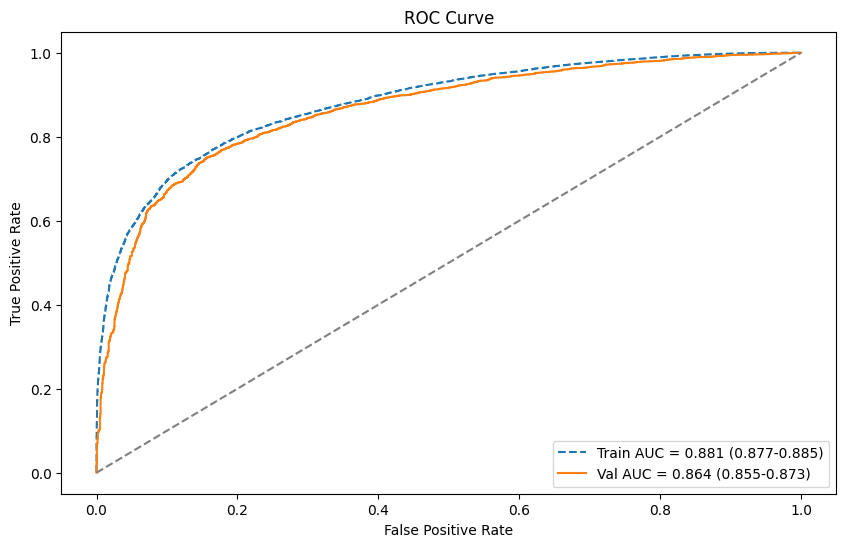

In [24]:
evaluate_model_metrics(lgbm_best, X_train_transformed, y_train, X_test_transformed, y_test)
plot_roc_curves(lgbm_best, X_train_transformed, y_train, X_test_transformed, y_test)

In [25]:
# 构建最佳超参数的模型
best_params = {'eta': 0.04564436219404251, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}
xgboost_best = xgb.XGBClassifier(**best_params)
xgboost_best.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04564436219404251,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

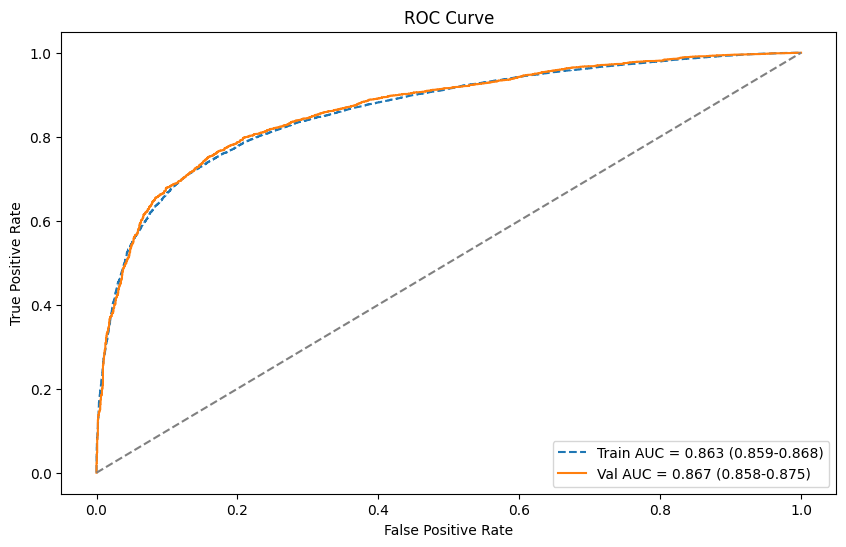

In [26]:
evaluate_model_metrics(xgboost_best, X_train_transformed, y_train, X_test_transformed, y_test)
plot_roc_curves(xgboost_best, X_train_transformed, y_train, X_test_transformed, y_test)

889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


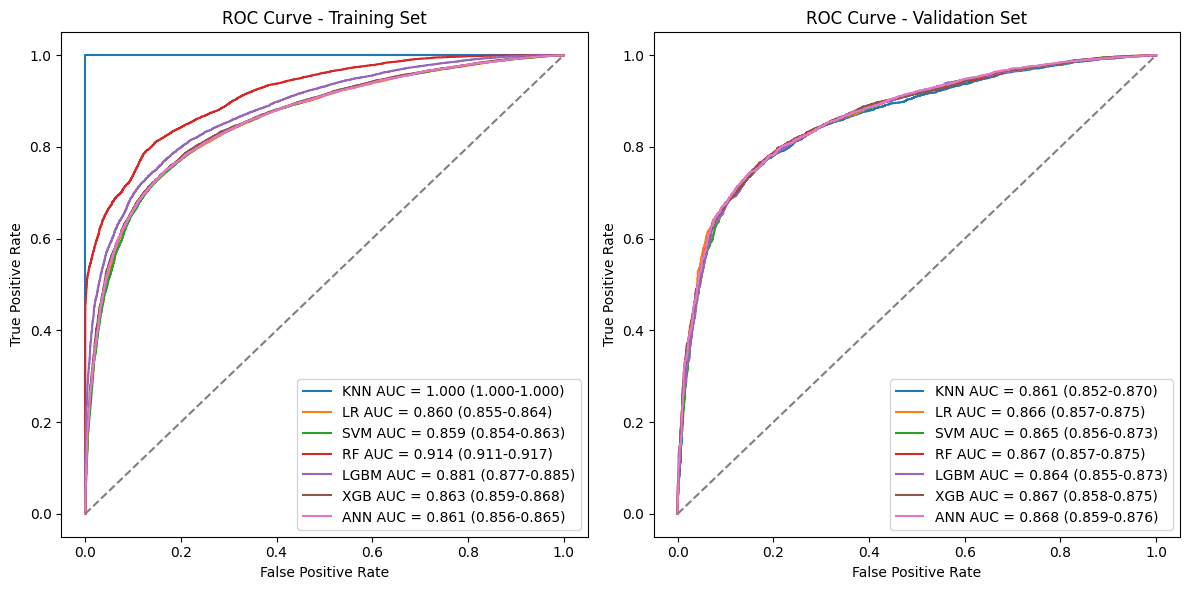

In [27]:
def plot_multiple_roc_curves(models, model_names, X_train, y_train, X_val, y_val, save_path=None):
    plt.figure(figsize=(12, 6))
    
    # 创建子图
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    
    # 对每个模型绘制 ROC 曲线
    for i, model in enumerate(models):
        metrics, fpr_train, tpr_train, fpr_val, tpr_val = evaluate_model_metrics(model, X_train, y_train, X_val, y_val)
        
        # 在训练集 ROC 曲线图上绘制
        ax1.plot(fpr_train, tpr_train, label=f'{model_names[i]} AUC = {metrics["train_roc_auc"]:.3f} ({metrics["train_roc_auc_ci_low"]:.3f}-{metrics["train_roc_auc_ci_upper"]:.3f})')

        # 在验证集 ROC 曲线图上绘制
        ax2.plot(fpr_val, tpr_val, label=f'{model_names[i]} AUC = {metrics["val_roc_auc"]:.3f} ({metrics["val_roc_auc_ci_low"]:.3f}-{metrics["val_roc_auc_ci_upper"]:.3f})')
    
    # 训练集 ROC 曲线图
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve - Training Set')
    ax1.legend(loc='lower right')
    ax1.grid(False)  # 关闭栅格
    
    # 验证集 ROC 曲线图
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve - Validation Set')
    ax2.legend(loc='lower right')
    ax2.grid(False)  # 关闭栅格
    
    # 调整布局
    plt.tight_layout()

    # 保存图形
    if save_path:
        plt.savefig(save_path, format='pdf')  # 保存为 PDF 格式

    # 显示图形
    plt.show()

# Example usage:
model_names = ['KNN', 'LR', 'SVM', 'RF', 'LGBM', 'XGB', 'ANN']
plot_multiple_roc_curves([knn_best, logistic_best, SVM_best, rf_best, lgbm_best, xgboost_best, ann_best], model_names, X_train_transformed, y_train, X_test_transformed, y_test, './figures/V2-ROC.pdf')


In [32]:
knn_dict = evaluate_model_metrics(knn_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
logistic_dict = evaluate_model_metrics(logistic_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
SVM_dict = evaluate_model_metrics(SVM_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
rf_dict = evaluate_model_metrics(rf_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
lgbm_dict = evaluate_model_metrics(lgbm_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
xgboost_dict = evaluate_model_metrics(xgboost_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]
ann_dict = evaluate_model_metrics(ann_best, X_train_transformed, y_train, X_test_transformed, y_test)[0]

df = pd.DataFrame([knn_dict, logistic_dict, SVM_dict,rf_dict,
                   lgbm_dict,xgboost_dict,ann_dict], index=['KNN', 'LR', 'SVM', 'rf', 'lgbm','xgb', 'ann'])
df.to_csv('./tables/V2-model_evaluation_results.csv', index=True)


889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


KNN     (1.000 - 1.000)
LR      (0.793 - 0.802)
SVM     (0.791 - 0.800)
rf      (0.833 - 0.841)
lgbm    (0.805 - 0.814)
xgb     (0.795 - 0.804)
ann     (0.793 - 0.802)
Name: accuary_train_ci, dtype: object

In [38]:
df['accuary_train_ci'] = "(" + df.iloc[:, 1].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 2].apply(lambda x: f"{x:.3f}") + ")"
df['accuary_val_ci'] = "(" + df.iloc[:, 4].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 5].apply(lambda x: f"{x:.3f}") + ")"
df['precision_train_ci'] = "(" + df.iloc[:, 7].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 8].apply(lambda x: f"{x:.3f}") + ")"
df['precision_val_ci'] = "(" + df.iloc[:, 10].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 11].apply(lambda x: f"{x:.3f}") + ")"
df['sensitivity_train_ci'] = "(" + df.iloc[:, 13].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 14].apply(lambda x: f"{x:.3f}") + ")"
df['sensitivity_val_ci'] = "(" + df.iloc[:, 16].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 17].apply(lambda x: f"{x:.3f}") + ")"
df['specificity_train_ci'] = "(" + df.iloc[:, 19].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 20].apply(lambda x: f"{x:.3f}") + ")"
df['specificity_val_ci'] = "(" + df.iloc[:, 22].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 23].apply(lambda x: f"{x:.3f}") + ")"
df['f1_train_ci'] = "(" + df.iloc[:, 25].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 26].apply(lambda x: f"{x:.3f}") + ")"
df['f1_val_ci'] = "(" + df.iloc[:, 28].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 29].apply(lambda x: f"{x:.3f}") + ")"
df['brier_train_ci'] = "(" + df.iloc[:, 31].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 32].apply(lambda x: f"{x:.3f}") + ")"
df['brier_val_ci'] = "(" + df.iloc[:, 34].apply(lambda x: f"{x:.3f}") + " - " + df.iloc[:, 35].apply(lambda x: f"{x:.3f}") + ")"
df.to_csv('./tables/V2-model_evaluation_results.csv', index=True)

In [18]:
# savemodels
import joblib

# 保存模型到本地
joblib.dump(knn_best, './Models/V2-knn_best_model.pkl')
joblib.dump(logistic_best, './Models/V2-logistic_best_model.pkl')
joblib.dump(SVM_best, './Models/V2-svm_best_model.pkl')

ann_best.save('./Models/V2-ann_best_model.h5')
lgbm_best.booster_.save_model('./Models/V2-lgbm_best_model.txt')
xgboost_best.save_model('./Models/V2-xgboost_best_model.json')

In [19]:
# Load models
knn_model = joblib.load('./Models/V2-knn_best_model.pkl')
logistic_model = joblib.load('./Models/V2-logistic_best_model.pkl')
SVM_model = joblib.load('./Models/V2-svm_best_model.pkl')

from tensorflow.keras.models import load_model
ann_model = load_model('./Models/V2-ann_best_model.h5')

lgb_model = lgb.Booster(model_file='./Models/V2-lgbm_best_model.txt')

xgb_model = xgb.Booster()
xgb_model.load_model('./Models/V2-xgboost_best_model.json')

In [20]:
import shap

def shap_explanation(models, model_names, X_train):
    for i, model in enumerate(models):
        print(f"Explaining {model_names[i]} model")
        
        if model_names[i] == 'KNN':
            # KNN doesn't directly support SHAP, so we'll approximate using a KNN explainer
            background_sample = shap.sample(X_train, 100)
            # 或者使用 K 均值聚类选取背景数据
            # background_kmeans = shap.kmeans(X_train, 100)
            explainer = shap.KernelExplainer(model.predict, background_sample)
            shap_values = explainer.shap_values(background_sample)
            shap.summary_plot(shap_values, background_sample, feature_names=background_sample.columns, show=False)
        elif model_names[i] == 'LR':
            explainer = shap.LinearExplainer(model, X_train)
            shap_values = explainer.shap_values(X_train)
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=False)
        elif model_names[i] == 'SVM':
            # KNN doesn't directly support SHAP, so we'll approximate using a KNN explainer
            background_sample = shap.sample(X_train, 100)
            explainer = shap.KernelExplainer(model.predict, background_sample)
            shap_values = explainer.shap_values(background_sample)
            shap.summary_plot(shap_values, background_sample, feature_names=background_sample.columns, show=False)
        elif model_names[i] == 'RF':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_train)
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=False)
        elif model_names[i] == 'LGBM':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_train)
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=False)
        elif model_names[i] == 'XGB':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_train)
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=False)
        elif model_names[i] == 'ANN':
            explainer = shap.DeepExplainer(model, X_train)
            shap_values = explainer.shap_values(X_train)
            shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=False)

       

In [21]:
one_hot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Get feature names after OneHotEncoding
one_hot_feature_names = one_hot_encoder.get_feature_names_out(input_features=categorical_cols)

# Combine numeric features with one-hot encoded feature names
numeric_feature_names = numeric_cols
all_feature_names = np.concatenate([numeric_feature_names, one_hot_feature_names])

# Create DataFrame with new feature names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)

Explaining LGBM model


e:\Users\admin\miniconda3\envs\tf2\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


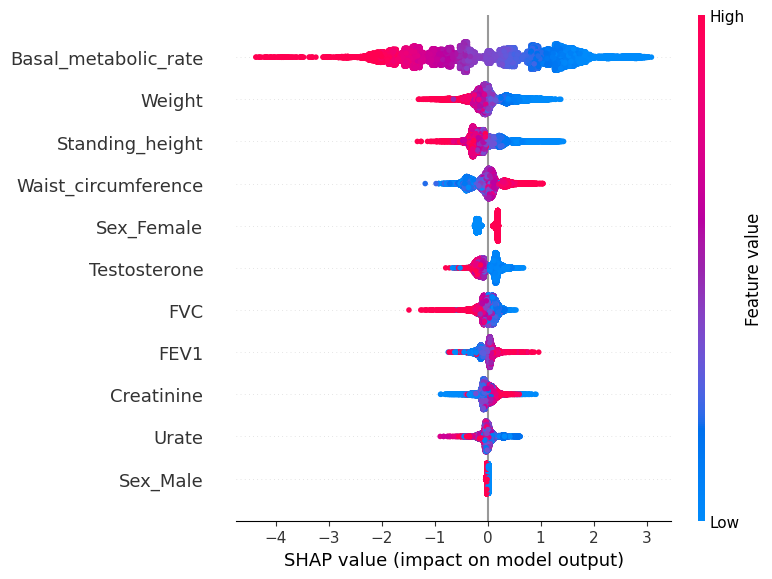

In [22]:
# Example usage:
# models = [knn_best, logistic_best, SVM_best, rf_best, lgbm_best, xgboost_best]
models = [lgbm_best]
# model_names = ['KNN', 'LR', 'SVM', 'RF', 'LGBM', 'XGB']
model_names = ['LGBM']

shap_explanation(models, model_names, X_train_transformed_df)

plt.savefig("./figures/V2-LGBM-shap_summary.pdf",dpi=300) #.png,.pdf will also support here
plt.show()

                 Feature  Importance
0   Basal_metabolic_rate    0.285712
9             Sex_Female    0.119424
2           Testosterone    0.112922
10              Sex_Male    0.105167
1        Standing_height    0.088861
3                 Weight    0.086915
5                    FVC    0.045563
4    Waist_circumference    0.042990
7             Creatinine    0.038513
6                   FEV1    0.037462
8                  Urate    0.036471


C:\Users\admin\AppData\Local\Temp\ipykernel_19764\3142857171.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


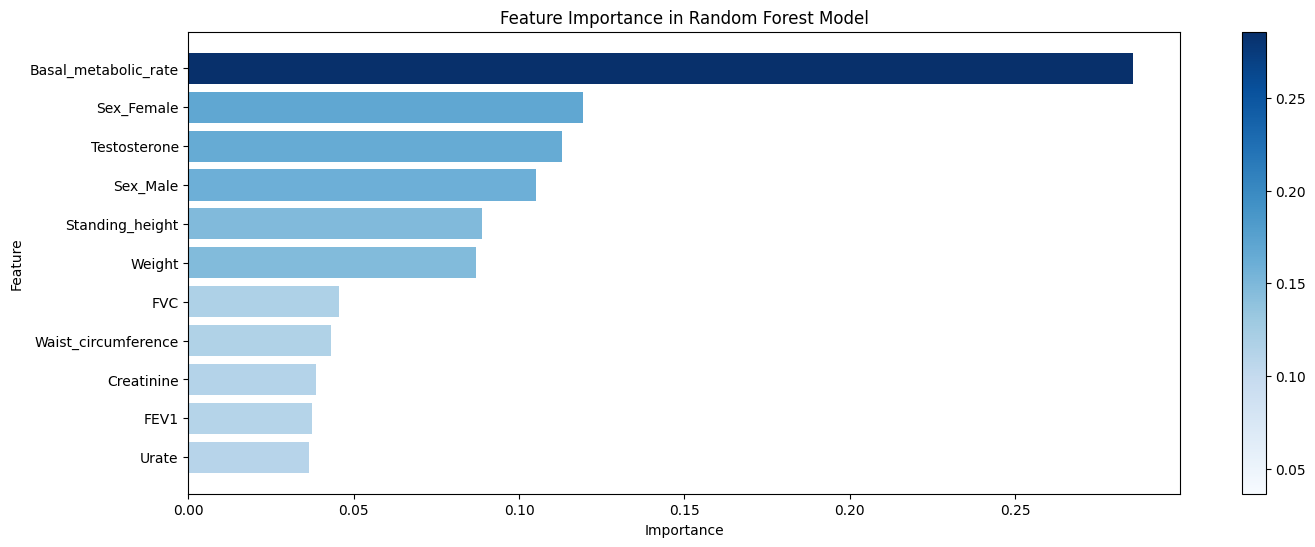

In [24]:
import matplotlib.cm as cm

feature_importances = rf_best.feature_importances_

importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# 设置单一色系渐变色（Blues色系），并让颜色范围从较浅的中间色开始
norm = plt.Normalize(importance_df['Importance'].min(), importance_df['Importance'].max())
cmap = cm.get_cmap('Blues')

# 将颜色范围调整为从中间偏深色开始，而不是最浅色
min_color_value = 0.3  # 设置最浅颜色的范围, 可以在 0 到 1 之间调整
colors = cmap(min_color_value + (1 - min_color_value) * norm(importance_df['Importance']))


# 创建图像和轴
fig, ax = plt.subplots(figsize=(16, 6))

# 创建水平条形图，并使用渐变色
bar = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance in Random Forest Model')

# 将重要性最高的特征显示在顶部
ax.invert_yaxis()

# 添加颜色条（colorbar）并指定轴
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax)  # 在当前的轴中添加颜色条

# 保存图像为 PDF
plt.savefig("./figures/V2-RF-importance.pdf", dpi=300)

# 显示图像
plt.show()

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


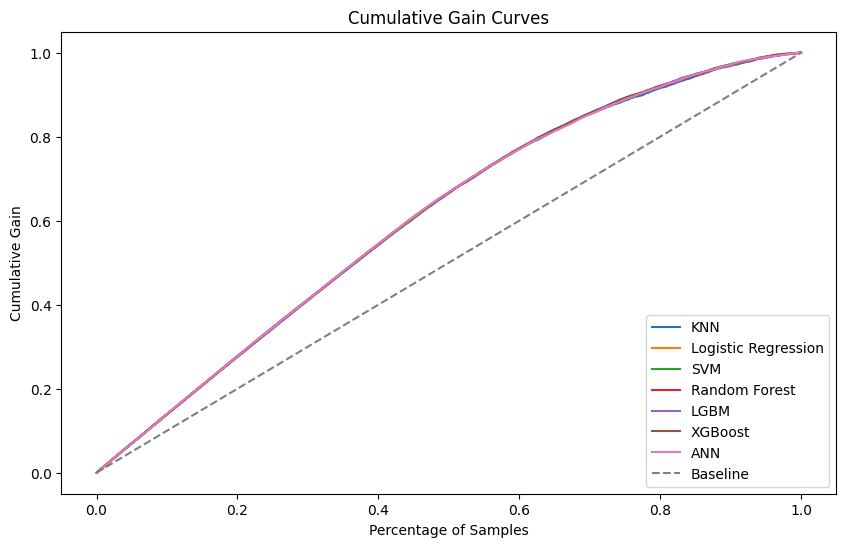

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 定义计算累积增益曲线的函数
def plot_cumulative_gain(y_true, *y_pred_probas, labels=None):
    plt.figure(figsize=(10, 6))

    for i, y_pred_proba in enumerate(y_pred_probas):
        # 提取正样本类别（1）的预测概率
        if y_pred_proba.ndim > 1:  # 如果有多列，取类别 1 的概率
            y_pred_proba = y_pred_proba[:, 1]

        # 按照预测概率排序，并排序y_true
        sorted_indices = np.argsort(y_pred_proba)[::-1]
        y_true_sorted = np.array(y_true)[sorted_indices]
        
        # 计算正样本的数量
        total_positives = np.sum(y_true)
        
        # 计算累积增益
        cum_gains = np.cumsum(y_true_sorted) / total_positives
        cum_percentage = np.arange(1, len(y_true_sorted) + 1) / len(y_true_sorted)
        
        # 绘制累积增益曲线
        label = labels[i] if labels is not None else f'Model {i + 1}'
        plt.plot(cum_percentage, cum_gains, label=label)

    # 添加参考线（对角线）
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline')

    # 图形细节
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Cumulative Gain')
    plt.title('Cumulative Gain Curves')
    plt.legend(loc='lower right')
    plt.show()



y_pred_proba_1 = knn_best.predict_proba(X_test_transformed)
y_pred_proba_2 = logistic_best.predict_proba(X_test_transformed)
y_pred_proba_3 = SVM_best.predict_proba(X_test_transformed)
y_pred_proba_4 = rf_best.predict_proba(X_test_transformed)
y_pred_proba_5 = lgbm_best.predict_proba(X_test_transformed)
y_pred_proba_6 = xgboost_best.predict_proba(X_test_transformed)
y_pred_proba_7 = ann_best.predict(X_test_transformed).flatten()


# 使用示例
# y_test: 真实标签 (0/1)，y_pred_proba: 模型预测的正样本概率
# 调用函数绘制多个模型的累积增益曲线
plot_cumulative_gain(
    y_test, 
    y_pred_proba_1, 
    y_pred_proba_2, 
    y_pred_proba_3, 
    y_pred_proba_4, 
    y_pred_proba_5, 
    y_pred_proba_6, 
    y_pred_proba_7, 
    labels=['KNN', 'Logistic Regression', 'SVM', 'Random Forest', 'LGBM', 'XGBoost', 'ANN']
)

889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


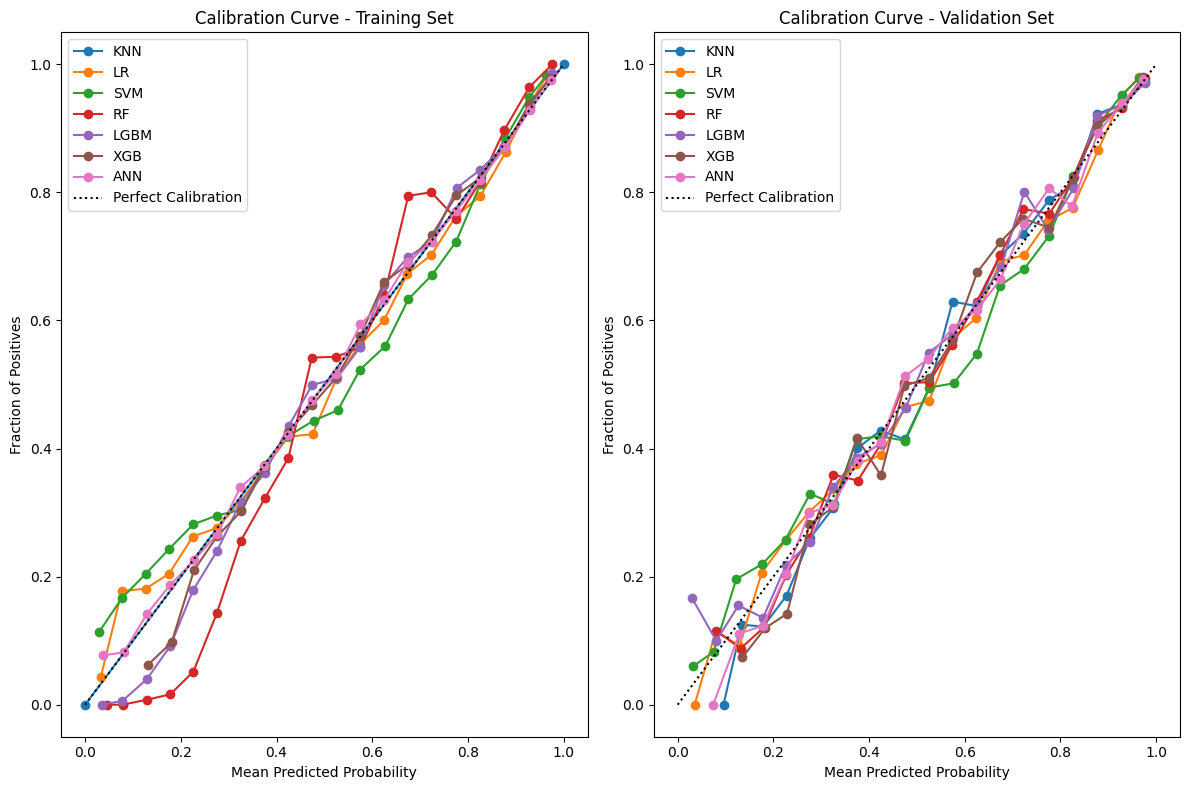

In [30]:

# 模型的预测概率 (需要已经训练好所有模型)
model_names = ['KNN', 'LR', 'SVM', 'RF', 'LGBM', 'XGB', 'ANN']
models = [knn_best, logistic_best, SVM_best, rf_best, lgbm_best, xgboost_best, ann_best]

# 保存训练集和验证集的预测概率
train_probas = []
val_probas = []

# 计算每个模型的预测概率
for model in models:
    # 训练集预测
    if model == ann_best:
        y_train_pred_proba = model.predict(X_train_transformed)  # 注意神经网络的处理
        y_val_pred_proba = model.predict(X_test_transformed)
    else:
        y_train_pred_proba = model.predict_proba(X_train_transformed)[:, 1]
        y_val_pred_proba = model.predict_proba(X_test_transformed)[:, 1]
    
    train_probas.append(y_train_pred_proba)
    val_probas.append(y_val_pred_proba)

# 创建图形对象
plt.figure(figsize=(12, 8))

# 在训练集上绘制校准曲线
plt.subplot(1, 2, 1)  # 左图: 训练集
for i, model_name in enumerate(model_names):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_train, train_probas[i], n_bins=20)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=model_name)
plt.plot([0, 1], [0, 1], 'k:', label='Perfect Calibration')
plt.title('Calibration Curve - Training Set')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')

# 在验证集上绘制校准曲线
plt.subplot(1, 2, 2)  # 右图: 验证集
for i, model_name in enumerate(model_names):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, val_probas[i], n_bins=20)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=model_name)
plt.plot([0, 1], [0, 1], 'k:', label='Perfect Calibration')
plt.title('Calibration Curve - Validation Set')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')

# 显示图形
plt.tight_layout()
    # 保存图形
plt.savefig('./figures/V2-Cal.pdf', format='pdf')

plt.show()